# Sarcasm Detection
https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

The goal is to build a model to detect whether a sentence is sarcastic or not, using
Bidirectional LSTMs.


## Install `Tensorflow2.0` 

In [ ]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 47kB/s 
     |████████████████████████████████| 450kB 31.9MB/s 
     |████████████████████████████████| 3.8MB 30.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a27e670f39cbf2e23d63a97aa5013549735fade4fe80295b189ad200b60d1c36
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


## Get Required Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set your project path 
project_path =  '/content/drive/My Drive/Paridhi_Colab/Sequential NLP Project/'

# Reading and Exploring Data

## Read Data "Sarcasm_Headlines_Dataset.json".  

In [ ]:
import pandas as pd
import os

In [ ]:
!ls '/content/drive/My Drive/Paridhi_Colab/Sequential NLP Project'

 glove.6B.zip
 NLP_Project_Sarcasm_Detection_Questions.ipynb
 Sarcasm_Headlines_Dataset.json
'Seq2Seq LSTM Model - Translation_with_prediction_Attention.ipynb'


In [ ]:
project_path

'/content/drive/My Drive/Paridhi_Colab/Sequential NLP Project/'

Sarcasm_Headlines_Dataset.json

In [ ]:
df = pd.read_json('/content/drive/My Drive/Paridhi_Colab/Sequential NLP Project/Sarcasm_Headlines_Dataset.json',lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
df.isna().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

In [ ]:
print('Different values in the target column:' , df['is_sarcastic'].unique())
print(df['headline'].nunique()) 
print(df['article_link'].nunique()) 

Different values in the target column: [0 1]
26602
26708


In [ ]:
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


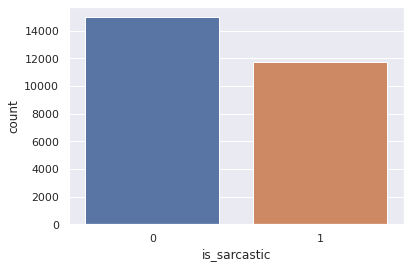

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(df['is_sarcastic'])

1 if the record is sarcastic otherwise 0

# Drop `article_link` from dataset
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [ ]:
df.drop(['article_link'],axis = 1, inplace = True)

In [ ]:
df.head(1)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0


In [ ]:
# Find a duplicate rows
df[df.duplicated(['headline','is_sarcastic'])].count()

headline        107
is_sarcastic    107
dtype: int64

In [ ]:
df.drop_duplicates(subset=['headline','is_sarcastic'],inplace = True)

In [ ]:
df.info() #26709-107 = 26602

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26602 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26602 non-null  object
 1   is_sarcastic  26602 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 623.5+ KB


In [ ]:
# lets check again
df[df.duplicated(['headline','is_sarcastic'])].count()

headline        0
is_sarcastic    0
dtype: int64

# Get the Length of each line and find the maximum length
As different lines are of different length. We need to pad the our sequences using the max length.

In [ ]:
#print(pd.Series({c: df[c].map(lambda x: len(str(x))).max() for c in df}))
import numpy as np
measurer = np.vectorize(len)
measurer(df['headline'].astype(str))

array([78, 84, 79, ..., 21, 60, 33])

In [ ]:
for a in df['headline']:
  if len(a) > 200:
    print(len(a)) 

237
238
254
228


In [ ]:
measurer(df['headline'].astype(str)).max()

254

In [ ]:
#Define maximum number of words to consider in each headline
#max_headline_length = 254

Other way for max length

In [ ]:
#Maximum length of sentence
maxlen = max([len(txt) for txt in df['headline']])
print('Maximum sentence length for Source language: ', maxlen)

Maximum sentence length for Source language:  254


# Modelling

In [ ]:
import numpy as np
from tensorflow.keras import backend

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters 

In [ ]:
max_features = 10000
#maxlen = 254
embedding_size = 200

## Apply Keras Tokenizer 


In [ ]:
headline_text = df['headline']

In [ ]:
#Tokenizer for headline column
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(headline_text) #Fit it on Source sentences

In [ ]:
headline_text

0        former versace store clerk sues over secret 'b...
1        the 'roseanne' revival catches up to our thorn...
2        mom starting to fear son's web series closest ...
3        boehner just wants wife to listen, not come up...
4        j.k. rowling wishes snape happy birthday in th...
                               ...                        
26704                 american politics in moral free-fall
26705                              america's best 20 hikes
26706                                reparations and obama
26707    israeli ban targeting boycott supporters raise...
26708                    gourmet gifts for the foodie 2014
Name: headline, Length: 26602, dtype: object

# Define X and y 

In [ ]:
X = tokenizer.texts_to_sequences(headline_text)
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26602
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

#Vocabulary size 


In [ ]:
#Vocablury
vocab_size = len(tokenizer.word_index)
print('vocablury size: ', vocab_size)

vocablury size:  29656


Indices of words

In [ ]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'by': 18,
 'this': 19,
 'after': 20,
 'up': 21,
 'out': 22,
 'be': 23,
 'how': 24,
 'as': 25,
 'it': 26,
 'that': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'his': 31,
 'what': 32,
 'he': 33,
 'all': 34,
 'just': 35,
 'who': 36,
 'has': 37,
 'will': 38,
 'more': 39,
 'one': 40,
 'report': 41,
 'into': 42,
 'year': 43,
 'why': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'day': 50,
 's': 51,
 'says': 52,
 'can': 53,
 'first': 54,
 'woman': 55,
 'time': 56,
 'like': 57,
 'her': 58,
 "trump's": 59,
 'old': 60,
 'no': 61,
 'get': 62,
 'off': 63,
 'an': 64,
 'life': 65,
 'people': 66,
 'obama': 67,
 'now': 68,
 'house': 69,
 'still': 70,
 'make': 71,
 'was': 72,
 'than': 73,
 "'": 74,
 'white': 75,
 'back': 76,
 'women': 77,
 'my': 78,
 'i': 79,
 'clinton': 80,
 'down': 81,
 'i

# Word Embedding

## Get Glove Word Embeddings

In [ ]:
glove_file = project_path + "glove.6B.zip"

In [ ]:
glove_file

'/content/drive/My Drive/Paridhi_Colab/Sequential NLP Project/glove.6B.zip'

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file 

In [ ]:
!ls

drive		   glove.6B.200d.txt  glove.6B.50d.txt
glove.6B.100d.txt  glove.6B.300d.txt  sample_data


In [ ]:
EMBEDDING_FILE = '/content/glove.6B.200d.txt' 

In [ ]:
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# a weight matrix for words 

In [ ]:
num_words = vocab_size +1

In [ ]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Create and Compile your Model  



In [ ]:
#Initialize model
backend.clear_session()
model = Sequential()

In [ ]:
### Embedding layer for hint 
## model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))

model.add(Dropout(0.2))

### Bidirectional LSTM layer for hint 
## model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.output

<tf.Tensor 'dense/Identity:0' shape=(None, None, 1) dtype=float32>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         5931400   
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         336896    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           257       
Total params: 6,268,553
Trainable params: 6,268,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Fit the model 


In [ ]:
batch_size = 100
epochs = 5

## Add your code here ##

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
model.fit(X_train,y_train,epochs=epochs ,batch_size=batch_size,validation_data=(X_test, y_test),verbose = 1)

Train on 21281 samples, validate on 5321 samples
Epoch 1/5
21281/21281 [==============================] - 576s 27ms/sample - loss: 0.6454 - accuracy: 0.6264 - val_loss: 0.6798 - val_accuracy: 0.5562
Epoch 2/5
21281/21281 [==============================] - 581s 27ms/sample - loss: 0.6018 - accuracy: 0.6743 - val_loss: 0.5083 - val_accuracy: 0.7869
Epoch 3/5
21281/21281 [==============================] - 555s 26ms/sample - loss: 0.6666 - accuracy: 0.5869 - val_loss: 0.6761 - val_accuracy: 0.5577
Epoch 4/5
21281/21281 [==============================] - 563s 26ms/sample - loss: 0.6600 - accuracy: 0.5913 - val_loss: 0.5136 - val_accuracy: 0.7879
Epoch 5/5
21281/21281 [==============================] - 573s 27ms/sample - loss: 0.4996 - accuracy: 0.7692 - val_loss: 0.4808 - val_accuracy: 0.8161
